# Use of EXIOBASE3.8
We will illustrate here the use of EXIOBASE by calculating EU GHG emissions from different perspectives.

Some of these results are used in the "Luxembourg in Transition" report.

Note: there is a bit of experimentation going on, for example the regionalization of the stressor matrix.

<thomas.gibon@list.lu>

Credit <maxime.agez@polymtl.ca> for the stressor extensions and characterization data

In [1]:
# Let's get comfortable first
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Import the necessary modules.

In [2]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import SPA
from matplotlib.patches import Rectangle

Import the data. You'll need to have downloaded EXIOBASE 3.8 files from https://zenodo.org/record/4277368 into `EXIOBASE_PATH`.
I recommend using the command described below.
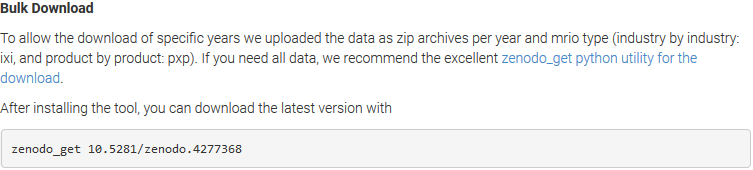

Then specify a year you want to work with. Note: in the 3.8 version, year 2019 has some issues, specifically for EU and Denmark in particular. You may want to choose another year instead.

The original characterization matrix is from https://zenodo.org/record/3955079/

...and you can find the stressors extension and characterization data at https://figshare.com/articles/dataset/Additional_environmental_extensions_for_EXIOBASE3_based_on_USEEEIO/12471278/1

In [3]:
year = 2018
EXIOBASE_PATH = '../EXIOBASE/'
# EXIOBASE_PATH = '../exiobase/'

Then, just import the IO system with `pymrio`:

In [4]:
io = mr.parse_exiobase3(path=EXIOBASE_PATH+'IOT_{}_pxp.zip'.format(year))

Import the population data.

In [5]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

In [6]:
io.calc_all()

Import additional stressors.

In [7]:
# Credit to Maxime Agez for the stressor extension
stressors=pd.read_csv(EXIOBASE_PATH+'Expanded_S.csv',
                     index_col=[0],
                     header=[0,1])

In [8]:
stressors.shape

(1766, 9800)

In [9]:
stressors.columns=io.A.columns
short_S=io.satellite.S
short_S.shape

(1113, 9800)

In [10]:
io.satellite.S=pd.concat([short_S,stressors],axis=0)

In [11]:
io.satellite.F=io.satellite.S.mul(io.x['indout'])

In [12]:
F_Y_padding=pd.DataFrame(np.zeros([stressors.shape[0],io.satellite.F_Y.shape[1]]),
                        index=stressors.index,
                        columns=io.satellite.F_Y.columns)

In [13]:
io.satellite.F_Y=io.satellite.F_Y.append(F_Y_padding)

Run the various calculations (satellite factors, footprint reports, ...)

Import characterization.

In [14]:
Q_base=pd.read_csv(EXIOBASE_PATH+'C_exio_IW.csv',
             index_col=[0])
padding=short_S.shape[0]-Q_base.shape[1]
Q_energy=pd.DataFrame(np.zeros([Q_base.shape[0],padding]),
                     index=Q_base.index,
                     columns=short_S.index[-padding:])
Q_ext=pd.read_csv(EXIOBASE_PATH+'C_expansion_IW.csv',
             index_col=[0])

In [15]:
Q_base.shape

(36, 1104)

In [16]:
Q=pd.concat([Q_base,Q_energy,Q_ext],axis=1)
Q.shape

(36, 2879)

In [17]:
impact = dict()

In [18]:
impact['S'] = Q.dot(io.satellite.S) # unit stressors, per M€ 
impact['F'] = Q.dot(io.satellite.F) # total stressors
impact['F_Y'] = Q.dot(io.satellite.F_Y) # same for households
impact['name'] = 'impact' # and name
io.impact = mr.Extension(**impact) # finally, add it as a proper extension

In [19]:
io.calc_all()

In [20]:
ind='Climate change, short term (kg CO2 eq (short))'

In [21]:
GWP100_factors=Q.loc[ind]
GWP100_factors[GWP100_factors!=0]

CO2 - combustion - air                                                     1.00
CH4 - combustion - air                                                    36.00
N2O - combustion - air                                                   298.00
CO - combustion - air                                                      1.57
CH4 - non combustion - Extraction/production of (natural) gas - air       36.00
                                                                         ...   
Nitrogen fluoride - air - unspecified                                  17900.00
Nitrogen trifluoride - air - unspecified                               17900.00
Propane, 1,1,1,3,3,3-hexafluoro-, hcfc-236fa - air - unspecified        9000.00
Propane, perfluoro- - air - unspecified                                 9880.00
Sulfuryl fluoride - air - unspecified                                   4730.00
Name: Climate change, short term (kg CO2 eq (short)), Length: 78, dtype: float64

In [22]:
GWP100_factors[GWP100_factors!=0].to_excel('GWP100_EXIOBASE_factors.xlsx')

In [23]:
FD=io.impact.F_Y.loc[ind].unstack()

In [24]:
pd.concat([
    io.impact.D_cba_reg.loc[ind],
    io.impact.D_pba_reg.loc[ind],
    io.impact.D_imp_reg.loc[ind],
    io.impact.D_exp_reg.loc[ind],
#     FD.loc[:,FD.sum(0)!=0]
    ],
  axis=1
 ).loc[['BE','DE','FR','LU']]

,"Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))"
region,,,,
BE,1.733630e+11,1.200066e+11,1.120951e+11,5.873873e+10
DE,1.152324e+12,9.809294e+11,4.718471e+11,3.004522e+11
FR,6.636409e+11,4.545440e+11,3.410432e+11,1.319463e+11
LU,1.551635e+10,1.063772e+10,1.297883e+10,8.100197e+09


In [25]:
io.population[['BE','DE','FR','LU']]

,BE,DE,FR,LU
population,11482000,83124000,64991000,604000


In [26]:
pd.concat([
    io.impact.D_cba_reg.loc[ind],
    io.impact.D_pba_reg.loc[ind],
    io.impact.D_imp_reg.loc[ind],
    io.impact.D_exp_reg.loc[ind],
#     FD.loc[:,FD.sum(0)!=0]
    ],
  axis=1
 )

,"Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))"
region,,,,
AT,1.185876e+11,8.281365e+10,6.002207e+10,2.424817e+10
BE,1.733630e+11,1.200066e+11,1.120951e+11,5.873873e+10
BG,5.372546e+10,5.487870e+10,1.727300e+10,1.842623e+10
CY,1.420980e+10,1.622181e+10,7.345498e+09,9.357511e+09
CZ,1.400520e+11,1.285387e+11,4.549430e+10,3.398097e+10
DE,1.152324e+12,9.809294e+11,4.718471e+11,3.004522e+11
DK,8.419418e+10,6.968187e+10,4.939938e+10,3.488707e+10
EE,2.042486e+10,2.217665e+10,7.567427e+09,9.319220e+09
ES,4.180119e+11,3.638354e+11,1.730045e+11,1.188280e+11


### Focus on research sector

In [27]:
pd.set_option('display.max_rows', 200)
research_employees_LU=io.satellite.D_pba['LU','Research and development services (73)'].iloc[9:15].sum()*1000

In [28]:
#https://statistiques.public.lu/stat/TableViewer/tableView.aspx?ReportId=13555&IF_Language=eng&MainTheme=4&FldrName=9&RFPath=2222
research_employees_LU=5468

In [29]:
io.impact.D_cba.loc[ind,('LU','Research and development services (73)')]

27411149.1201913

In [30]:
pd.set_option('display.max_rows', 200)
io.impact.D_cba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

5013.0119093254025

In [31]:
io.impact.D_pba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

431.3919930322229

In [32]:
io.impact.D_cba.loc[ind,'LU'].sum()

14056898689.000961

In [33]:
io.impact.D_cba.loc[ind,'LU'].sum()/440000

31947.49702045673

## Making own indicators

In [34]:
GWP100_unfccc=pd.Series(
[1,1,1,
34,34,34,34,34,34,34,34,34,34,
265,265]
    ,
index=
['CO2 - combustion - air',
 'CO2 - non combustion - Cement production - air',
 'CO2 - non combustion - Lime production - air',
 'CH4 - combustion - air',
 'CH4 - non combustion - Extraction/production of (natural) gas - air',
 'CH4 - non combustion - Extraction/production of crude oil - air',
 'CH4 - non combustion - Mining of antracite - air',
 'CH4 - non combustion - Mining of bituminous coal - air',
 'CH4 - non combustion - Mining of coking coal - air',
 'CH4 - non combustion - Mining of lignite (brown coal) - air',
 'CH4 - non combustion - Mining of sub-bituminous coal - air',
 'CH4 - non combustion - Oil refinery - air',
 'CH4 - agriculture - air',
 'N2O - combustion - air',
 'N2O - agriculture - air']
)

GWP100_unfccc

CO2 - combustion - air                                                   1
CO2 - non combustion - Cement production - air                           1
CO2 - non combustion - Lime production - air                             1
CH4 - combustion - air                                                  34
CH4 - non combustion - Extraction/production of (natural) gas - air     34
CH4 - non combustion - Extraction/production of crude oil - air         34
CH4 - non combustion - Mining of antracite - air                        34
CH4 - non combustion - Mining of bituminous coal - air                  34
CH4 - non combustion - Mining of coking coal - air                      34
CH4 - non combustion - Mining of lignite (brown coal) - air             34
CH4 - non combustion - Mining of sub-bituminous coal - air              34
CH4 - non combustion - Oil refinery - air                               34
CH4 - agriculture - air                                                 34
N2O - combustion - air   

Now we prepare the data for plotting.

## Bar chart of per-capita EU GHG emissions

In [35]:
method = GWP100_unfccc # hand-made method, in case you set up other method vectors

GHG_cba_tot = method.dot(io.satellite.D_cba_reg.loc[method.index])
GHG_pba_tot = method.dot(io.satellite.D_pba_reg.loc[method.index])
GHG_cba_cap = method.dot(io.satellite.D_cba_cap.loc[method.index])
GHG_pba_cap = method.dot(io.satellite.D_pba_cap.loc[method.index])
GHG_imp_tot = method.dot(io.satellite.D_imp_reg.loc[method.index])
GHG_exp_tot = method.dot(io.satellite.D_exp_reg.loc[method.index])
GHG_imp_cap = method.dot(io.satellite.D_imp_cap.loc[method.index])
GHG_exp_cap = method.dot(io.satellite.D_exp_cap.loc[method.index])
GHG_direct=method.dot(io.satellite.F_Y.loc[method.index]).groupby('region').sum()



In [36]:
footprints_EU_all_GHGs=pd.concat([io.impact.D_pba_reg.loc[ind],
                         io.impact.D_imp_reg.loc[ind],
                         io.impact.D_exp_reg.loc[ind],
                         io.impact.D_cba_reg.loc[ind],
                         io.impact.F_Y.loc[ind].groupby('region').sum()],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions'))

In [37]:
footprints_EU_UNFCCC=pd.concat([GHG_pba_tot,
                         GHG_imp_tot,
                         GHG_exp_tot,
                         GHG_cba_tot,
                         GHG_direct],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000

In [38]:
footprints_EU_cap=pd.concat([GHG_pba_cap,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_cap,
                             GHG_direct.div(population.loc[year])],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000

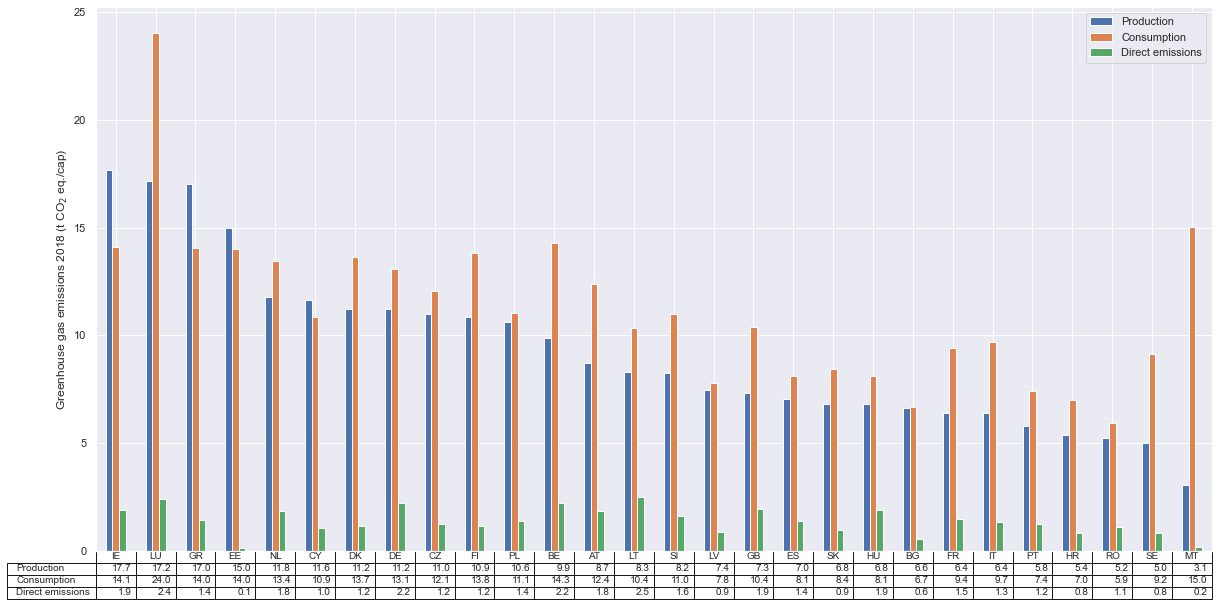

In [39]:
sns.set(font_scale=1)

fig,ax=plt.subplots(figsize=(20,10))
footprints_EU_cap.plot(kind='bar',ax=ax)
ax.set_ylabel(f'Greenhouse gas emissions {year} (t CO$_{2}$ eq./cap)')
ax.set_xticklabels([])
table = plt.table(colLabels=footprints_EU_cap.index,
          rowLabels=footprints_EU_cap.columns,
          cellText=footprints_EU_cap.T.round(1).values,loc='bottom')

table.set_fontsize(10)

In [40]:
footprints_EU_tot=pd.concat([GHG_pba_tot,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_tot,
                             GHG_direct],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)*1e-9
footprints_EU_tot.to_csv('footprint_EU_{}.csv'.format(year))

## Focus on Luxembourg
### Carbon footprint
I think $GHG_{cons pro LU}=\widehat{S_{GWP100}}L\widehat{y_{LU}}$ should work?

In [41]:
Y_LU = io.Y['LU'].sum(1)

In [42]:
GHG_cons_pro_LU=io.L.multiply(io.impact.S.loc[ind],axis=0).multiply(Y_LU)

In [43]:
GHG_cons_pro_LU['TOTAL'] = GHG_cons_pro_LU.sum(1)
GHG_cons_pro_LU.loc['TOTAL'] = GHG_cons_pro_LU.sum(0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='region-sector'>

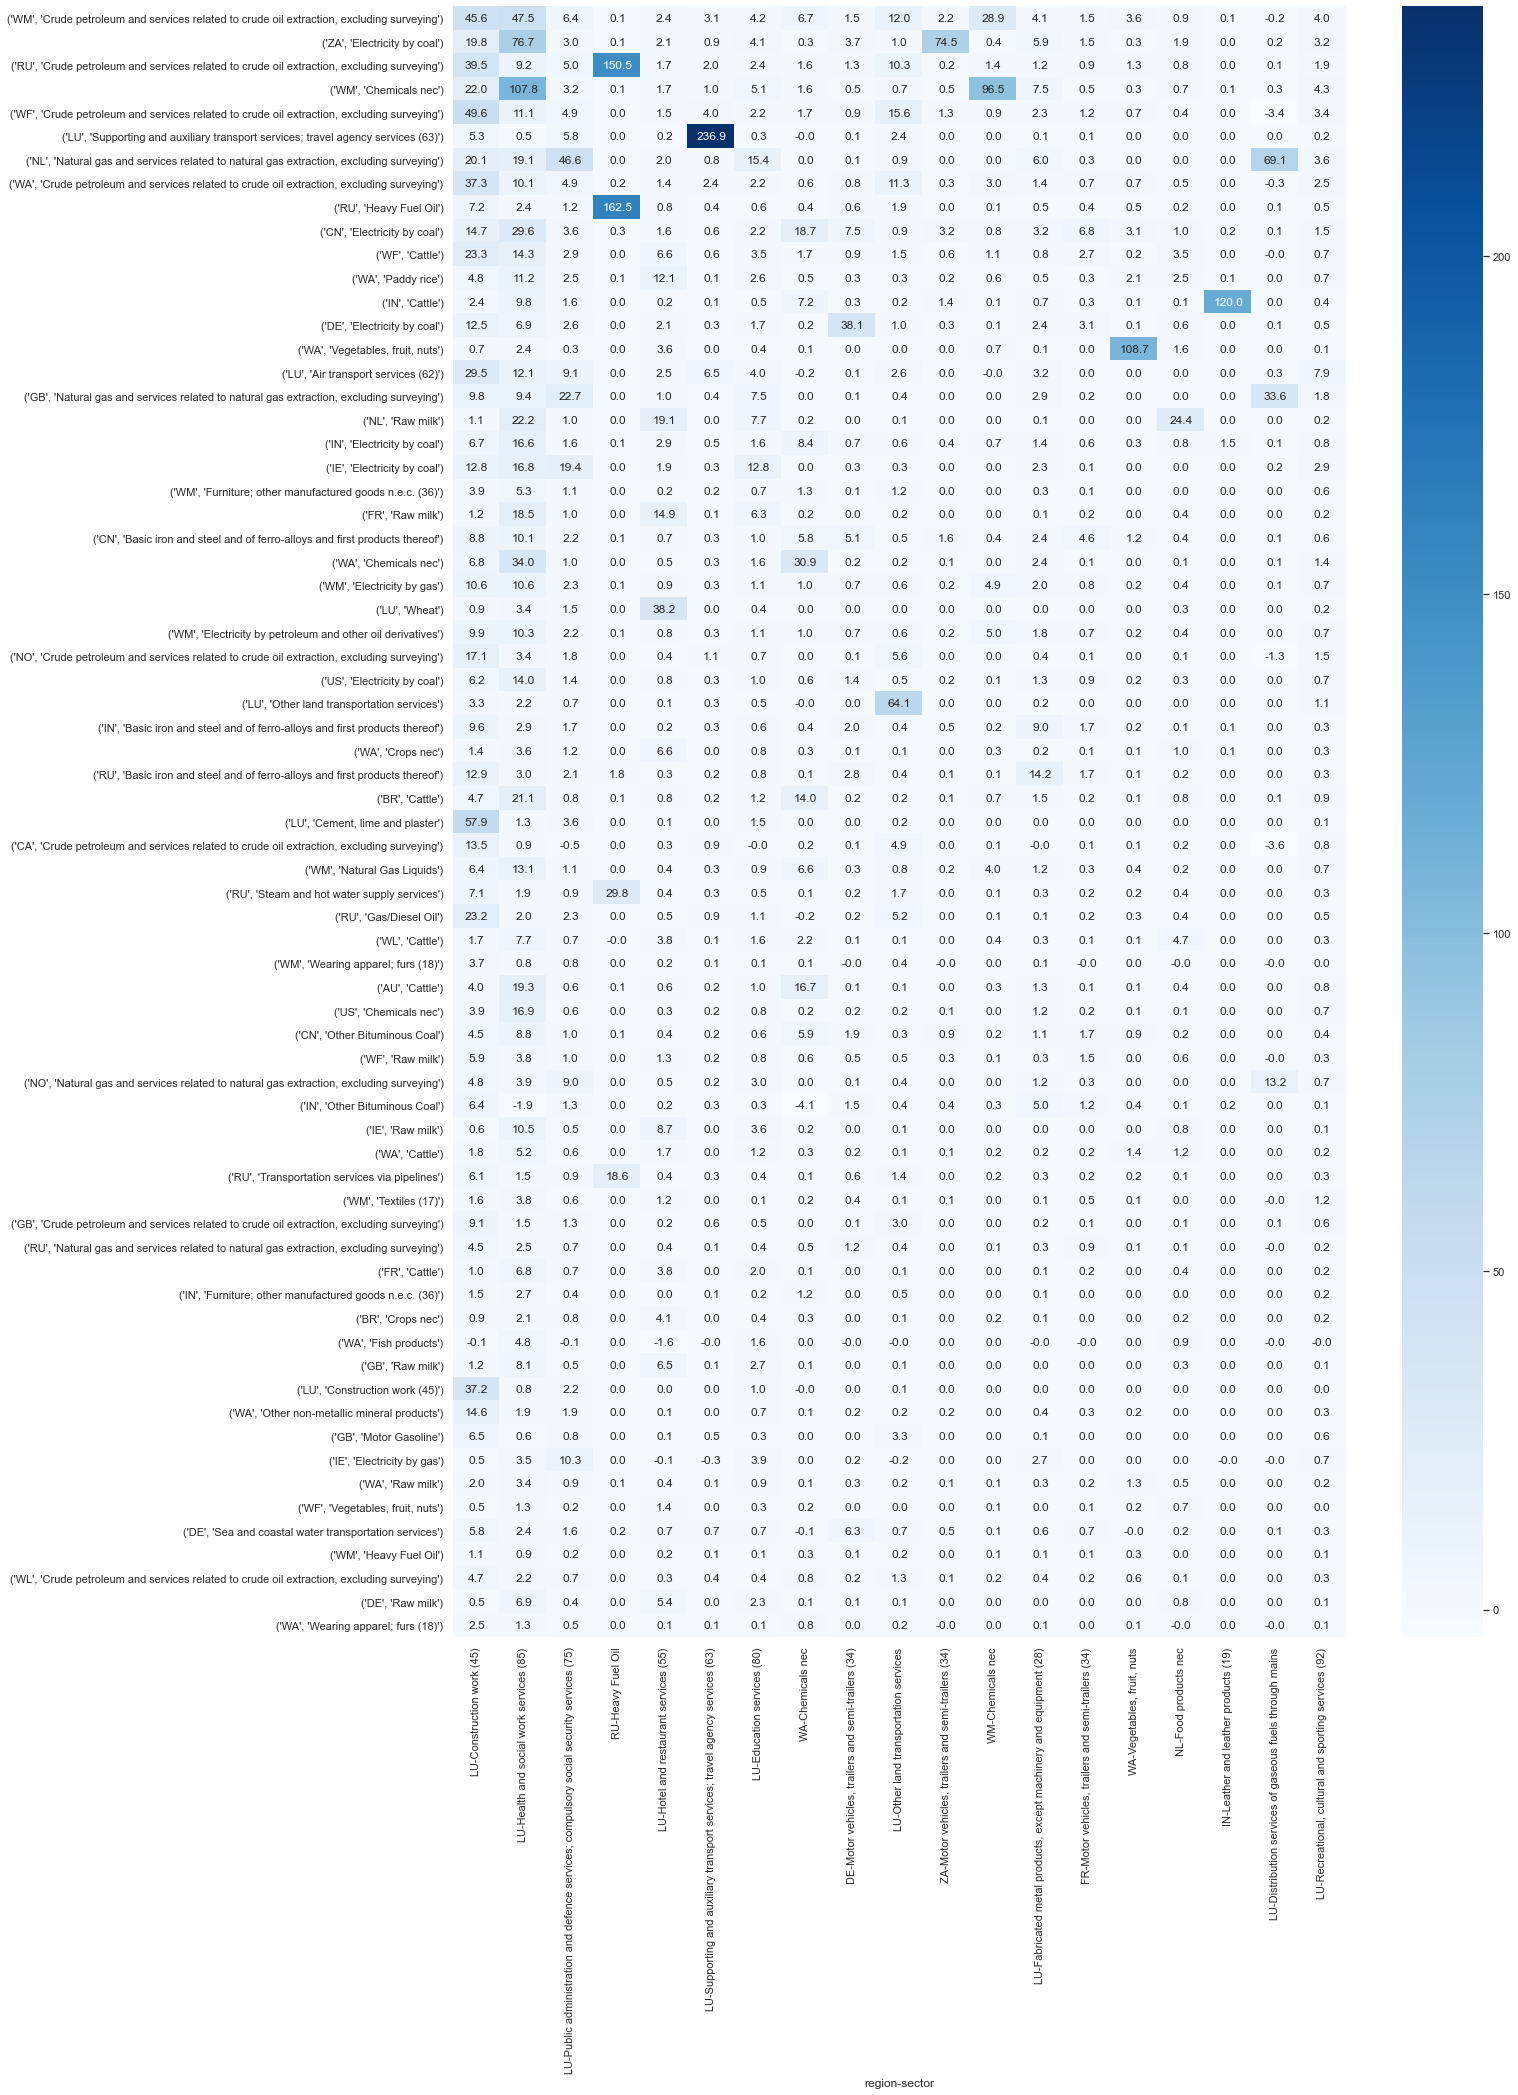

In [44]:
GHG_snap = GHG_cons_pro_LU.sort_values('TOTAL',axis=1,ascending=False).sort_values('TOTAL',ascending=False).iloc[:70,:20].drop('TOTAL').drop('TOTAL',axis=1)*1e-6
fig, ax = plt.subplots(figsize=(20,30))
sns.heatmap(GHG_snap, annot=True,
#             norm=matplotlib.colors.LogNorm(vmin=1e-6,
#                                            vmax=GHG_snap.max().max()),
            cmap='Blues',
           fmt='.1f')

In [45]:
# We can do a quick structural path analysis

region='LU'
scale=1

paths = SPA.SPA(io.impact.S.loc[ind]*scale,
            io.A,
            io.Y[region].sum(1),
            Tmax=30,
            threshold=.0001,
            filename=f'test_{region}_{ind}.csv',
            M=io.impact.M.loc[ind]*scale,
            direct=io.impact.F_Y[region].sum(1)[ind]*scale)

In [46]:
paths

,sequence,value,contribution,path
TOTAL,[],1.40569e+10,1,[]
REST,[],6.13644e+09,0.436543,[]
DIRECT,[],1.45945e+09,0.103825,[]
840,[3562],2.34069e+08,0.0166516,"[(LU, Supporting and auxiliary transport servi..."
1638,[7272],1.625e+08,0.0115601,"[(RU, Heavy Fuel Oil)]"
...,...,...,...,...
454,"[3539, 3540]",453.125,3.22351e-08,"[(LU, Transmission services of electricity), (..."
1224,"[3574, 8889, 8446]",234.477,1.66805e-08,"[(LU, Health and social work services (85)), (..."
1879,"[8889, 8446]",225.931,1.60726e-08,"[(WA, Chemicals nec), (ID, products of Vegetab..."
387,"[3495, 3495]",139.469,9.92171e-09,"[(LU, Rubber and plastic products (25)), (LU, ..."


### Carbon flows

We make a map of carbon flows, and then try to aggregate that to match the region classification we use.

In [94]:
# Get the GHG emissions embodied in final demand: diag(S)*L*diag(y)
GHG_cons_pro=io.L.multiply(io.impact.S.loc[ind],axis=0).dot(io.Y.sum(level='region',axis=1)).sum(level='region',axis=0)
# GHG_cons_pro['TOTAL'] = GHG_cons_pro.sum(1)
# GHG_cons_pro.loc['TOTAL'] = GHG_cons_pro.sum(0)

In [105]:
GHG_cons_pro_FD=pd.DataFrame(np.diag(io.impact.F_Y.sum(level='region',axis=1).loc[ind]),index=GHG_cons_pro.index,columns=GHG_cons_pro.columns)
GHG_cons_pro_tot=GHG_cons_pro+GHG_cons_pro_FD

### Aggregate and disaggregate for the functional area, Luxembourg excluded (population-wise, i.e. only consumption-based would make sense)
We need a 49 to 4 matrix, to reaggregate for Luxembourg, functional area, EU28, and rest of the world.
Aggregating the regions will lose the multiplier details and generate discrepancies between aggregated and non-aggregated footprints. To remediate this, we will also aggregate the carbon flow map calculated above.

In [144]:
reg_agg_matrix = np.zeros([49,7])

# We'll disaggregate the various countries to compose the functional area
# Flows will follow population, for a lack of a better proxy for emissions
# This is probably wrong for territorial emissions, but should hold for consumption

population_FA=pd.Series({'BE':225772,
                         'DE':378881,
                         'FR':781852},
                          name='population')

FA_shares=population_FA/io.population
FA_shares.fillna(inplace=True, value=0)
FA_shares=FA_shares.reindex_like(io.population)

reg_agg_matrix[io.get_regions()=='LU',0] = 1
reg_agg_matrix[:,1] = FA_shares
reg_agg_matrix[io.get_regions()=='BE',2] = 1-reg_agg_matrix[io.get_regions()=='BE',1]
reg_agg_matrix[io.get_regions()=='DE',3] = 1-reg_agg_matrix[io.get_regions()=='DE',1]
reg_agg_matrix[io.get_regions()=='FR',4] = 1-reg_agg_matrix[io.get_regions()=='FR',1]
reg_agg_matrix[:28,5] = 1-reg_agg_matrix[:28,:5].sum(1)
reg_agg_matrix[:,6] = 1-reg_agg_matrix[:,:6].sum(1)

reg_agg_matrix=reg_agg_matrix.T # argh, the matrix was transposed

assert all(reg_agg_matrix.sum(0)==1)

In [145]:
reg_agg_matrix.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [146]:
# Reaggregate
reg_agg_names=['LU','Functional\narea','BE','DE','FR','EU28','World']
ioagg = io.aggregate(region_agg=reg_agg_matrix,
                     region_names=reg_agg_names,
                        inplace=False)

In [60]:
# Calculate the new system
ioagg.calc_all()

In [61]:
# ioagg.calc_extensions??

Run a few checks because it's easy to get lost...

In [62]:
# intermediate consumption emissions
ioagg.impact.D_cba.loc[ind,'LU'].sum()

14056898689.000961

In [63]:
# final consumption direct emissions
ioagg.impact.F_Y.loc[ind,'LU'].sum()

1459452836.564003

In [64]:
# total emissions attributable to consumption
ioagg.impact.D_cba.loc[ind,'LU']

sector
Paddy rice                                                                                                                                 2.096554e+07
Wheat                                                                                                                                      6.125979e+07
Cereal grains nec                                                                                                                          7.704388e+06
Vegetables, fruit, nuts                                                                                                                    3.734917e+08
Oil seeds                                                                                                                                  3.780938e+07
Sugar cane, sugar beet                                                                                                                     9.441750e+02
Plant-based fibers                                                               

In [65]:
ioagg.impact.D_cba_cap.loc[ind]

region
LU       25689.323718
FA       12004.920158
BE       15098.672614
DE       13862.713915
FR       10211.274512
EU28     10975.830701
World     6395.756787
Name: Climate change, short term (kg CO2 eq (short)), dtype: float64

What happens if we aggregate the previous results?

In [147]:
GHG_summary=pd.DataFrame(reg_agg_matrix.dot(GHG_cons_pro_tot.dot(reg_agg_matrix.T)),
             index=reg_agg_names,
             columns=reg_agg_names)

Calculate the deviation with the "official" number...

In [148]:
abs((GHG_summary.sum()['LU']-io.impact.D_cba_reg.loc[ind,'LU'])/io.impact.D_cba_reg.loc[ind,'LU'])

2.458501445613584e-16

OK, still works!

In [149]:
GHG_summary *= 1e-9 # convert to Mt
GWP_all_toplot   = GHG_summary.applymap(lambda x: round(x, int(np.floor(1 - np.floor(np.log10(x))))))
GWP_prod_toplot  = [*zip(GHG_summary.sum(1).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x)))))))]
GWP_cons_toplot  = [GHG_summary.sum(0).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]
GWP_total_toplot = [pd.Series(GHG_summary.sum().sum()).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]

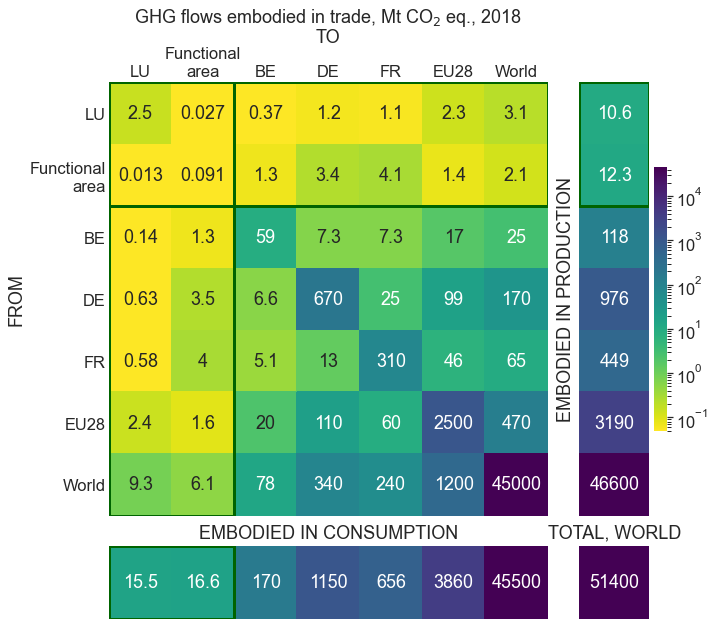

In [150]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(10, 745/88),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 2],
                                    'height_ratios': [10, 745/888*2],
                                    'wspace': 0.12,
                                    'hspace': 0.12,
                                    'bottom': 0})

cmap  = 'viridis_r'


sns.heatmap(GWP_all_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=1,
                                           vmax=GHG_summary.max().max()),
           fmt='g',
            cmap=cmap,
            cbar=False,
           ax=ax[0,0])

sns.heatmap(GWP_prod_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            
            cmap=cmap,
           fmt='g',
           ax=ax[0,1])

sns.heatmap(GWP_cons_toplot, annot=True,
#             annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='g',
           ax=ax[1,0])

sns.heatmap(GWP_total_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='g',
           ax=ax[1,1])

ax[0,0].set_xlabel('TO')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_ylabel('FROM')
ax[0,0].set_title('GHG flows embodied in trade, Mt CO$_2$ eq., 2018')
ax[0,0].xaxis.tick_top()
ax[0,0].tick_params(axis=u'both', which=u'both',length=0)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel('EMBODIED IN PRODUCTION')

ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_xlabel('TOTAL, WORLD',labelpad=8)
ax[1,1].xaxis.set_label_position('top') 

ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION',labelpad=8)
ax[1,0].xaxis.set_label_position('top') 
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xticks([])

hili=0
ax[0,0].add_patch(Rectangle((0, hili), 7, 2, fill=False, edgecolor='darkgreen', lw=3))
ax[0,0].add_patch(Rectangle((hili, 0), 2, 7, fill=False, edgecolor='darkgreen', lw=3))
ax[0,1].add_patch(Rectangle((0, hili), 1, 2, fill=False, edgecolor='darkgreen', lw=3))
ax[1,0].add_patch(Rectangle((hili, 0), 2, 1, fill=False, edgecolor='darkgreen', lw=3))


# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.svg'.format(year),
            facecolor='white',
            edgecolor='none',
            bbox_inches='tight')

### Aggregate and disaggregate for the functional area, Luxembourg included (population-wise, i.e. only consumption-based would make sense)
We need a 49 to 3 matrix, to reaggregate for Luxembourg + functional area, EU28, and rest of the world.

In [138]:
reg_agg_matrix = np.zeros([49,6])

# We'll disaggregate the various countries to compose the functional area
# Flows will follow population, for a lack of a better proxy for emissions
# This is probably wrong for territorial emissions, but should hold for consumption

population_FA=pd.Series({'LU':io.population['LU'],
                         'BE':225772,
                         'DE':378881,
                         'FR':781852},
                          name='population')

FA_shares=population_FA/io.population
FA_shares.fillna(inplace=True, value=0)
FA_shares=FA_shares.reindex_like(io.population)

reg_agg_matrix[:,0] = FA_shares
reg_agg_matrix[io.get_regions()=='BE',1] = 1-reg_agg_matrix[io.get_regions()=='BE',1]
reg_agg_matrix[io.get_regions()=='DE',2] = 1-reg_agg_matrix[io.get_regions()=='DE',1]
reg_agg_matrix[io.get_regions()=='FR',3] = 1-reg_agg_matrix[io.get_regions()=='FR',1]
reg_agg_matrix[:28,4] = 1-reg_agg_matrix[:28,:4].sum(1)
reg_agg_matrix[:,5] = 1-reg_agg_matrix[:,:5].sum(1)

reg_agg_matrix=reg_agg_matrix.T # argh, the matrix was transposed

assert all(reg_agg_matrix.sum(0)==1)

# Reaggregate
reg_agg_names=['Functional\narea','BE','DE','FR','EU28','World']

# ioagg = io.aggregate(region_agg=reg_agg_matrix,
#                      region_names=reg_agg_names,
#                         inplace=False)

# # Calculate the new system
# ioagg.calc_all()

# ioagg.calc_extensions()

# ioagg.impact.D_cba_cap.loc[ind].plot(kind='bar')

In [139]:
GHG_summary=pd.DataFrame(reg_agg_matrix.dot(GHG_cons_pro_tot.dot(reg_agg_matrix.T)),
             index=reg_agg_names,
             columns=reg_agg_names)

In [140]:
GHG_summary *= 1e-9 # convert to Mt
GWP_all_toplot   = GHG_summary.applymap(lambda x: round(x, int(np.floor(1 - np.floor(np.log10(x))))))
GWP_prod_toplot  = [*zip(GHG_summary.sum(1).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x)))))))]
GWP_cons_toplot  = [GHG_summary.sum(0).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]
GWP_total_toplot = [pd.Series(GHG_summary.sum().sum()).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]

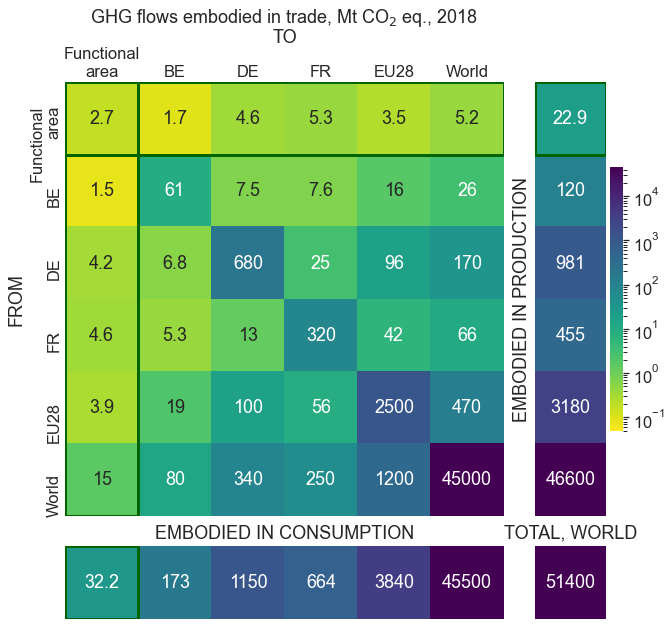

In [142]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(10, 745/88),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 2],
                                    'height_ratios': [10, 745/888*2],
                                    'wspace': 0.12,
                                    'hspace': 0.12,
                                    'bottom': 0})

cmap  = 'viridis_r'


sns.heatmap(GWP_all_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=1,
                                           vmax=GHG_summary.max().max()),
           fmt='g',
            cmap=cmap,
            cbar=False,
           ax=ax[0,0])

sns.heatmap(GWP_prod_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            
            cmap=cmap,
           fmt='g',
           ax=ax[0,1])

sns.heatmap(GWP_cons_toplot, annot=True,
#             annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='g',
           ax=ax[1,0])

sns.heatmap(GWP_total_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='g',
           ax=ax[1,1])

ax[0,0].set_xlabel('TO')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_ylabel('FROM')
ax[0,0].set_title('GHG flows embodied in trade, Mt CO$_2$ eq., 2018')
ax[0,0].xaxis.tick_top()
ax[0,0].tick_params(axis=u'both', which=u'both',length=0)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel('EMBODIED IN PRODUCTION')

ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_xlabel('TOTAL, WORLD',labelpad=8)
ax[1,1].xaxis.set_label_position('top') 

ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION',labelpad=8)
ax[1,0].xaxis.set_label_position('top') 
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xticks([])

hili=0
ax[0,0].add_patch(Rectangle((0, hili), 6, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[0,0].add_patch(Rectangle((hili, 0), 1, 6, fill=False, edgecolor='darkgreen', lw=3))
ax[0,1].add_patch(Rectangle((0, hili), 1, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[1,0].add_patch(Rectangle((hili, 0), 1, 1, fill=False, edgecolor='darkgreen', lw=3))


# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.svg'.format(year),
            facecolor='white',
            edgecolor='none',
            bbox_inches='tight')

## Heatmap of global (or EU) GHG emissions embodied in trade

In [152]:
sns.set(font_scale=1)

n_sectors   = 200
n_sectors_Y = 7

# create the GHG factors in GWP100 
S_GWP   = io.impact.S.loc[ind]
F_GWP_Y = io.impact.F_Y.loc[ind]

# and calculate the greenhouse gas emissions per sector of consumption for the intermediate consumption
GHG_cons_total = io.L.multiply(S_GWP,axis=0).dot(io.Y)

# group by region (we don't want sector resolution) and convert to Mt
GHG_cons_to_plot = GHG_cons_total.groupby('region',
                                    axis=1).sum().groupby('region',
                                                           axis=0).sum().reindex(io.get_regions(),
                                                                                 axis=0).reindex(io.get_regions(),
                                                                                                 axis=1)*1e-9

# same, for the emissions of final demand
GHG_cons_Y = pd.DataFrame(block_diag(*[F_GWP_Y.iloc[i*n_sectors_Y:(i+1)*n_sectors_Y] for i in range(49)]),
            index   = io.get_regions(),
            columns = io.Y.columns)
GHG_cons_Y_to_plot = GHG_cons_Y.groupby('region',axis=1).sum().reindex(io.get_regions(), axis=1)*1e-9

# sum them both
GHG_cons = GHG_cons_to_plot + GHG_cons_Y_to_plot

# and create column and row for production-based emissions and consumption-based emissions 
GHG_cons['EMBODIED IN\nPRODUCTION'] = GHG_cons.sum(1)
GHG_cons.loc['EMBODIED IN\nCONSUMPTION'] = GHG_cons.sum()

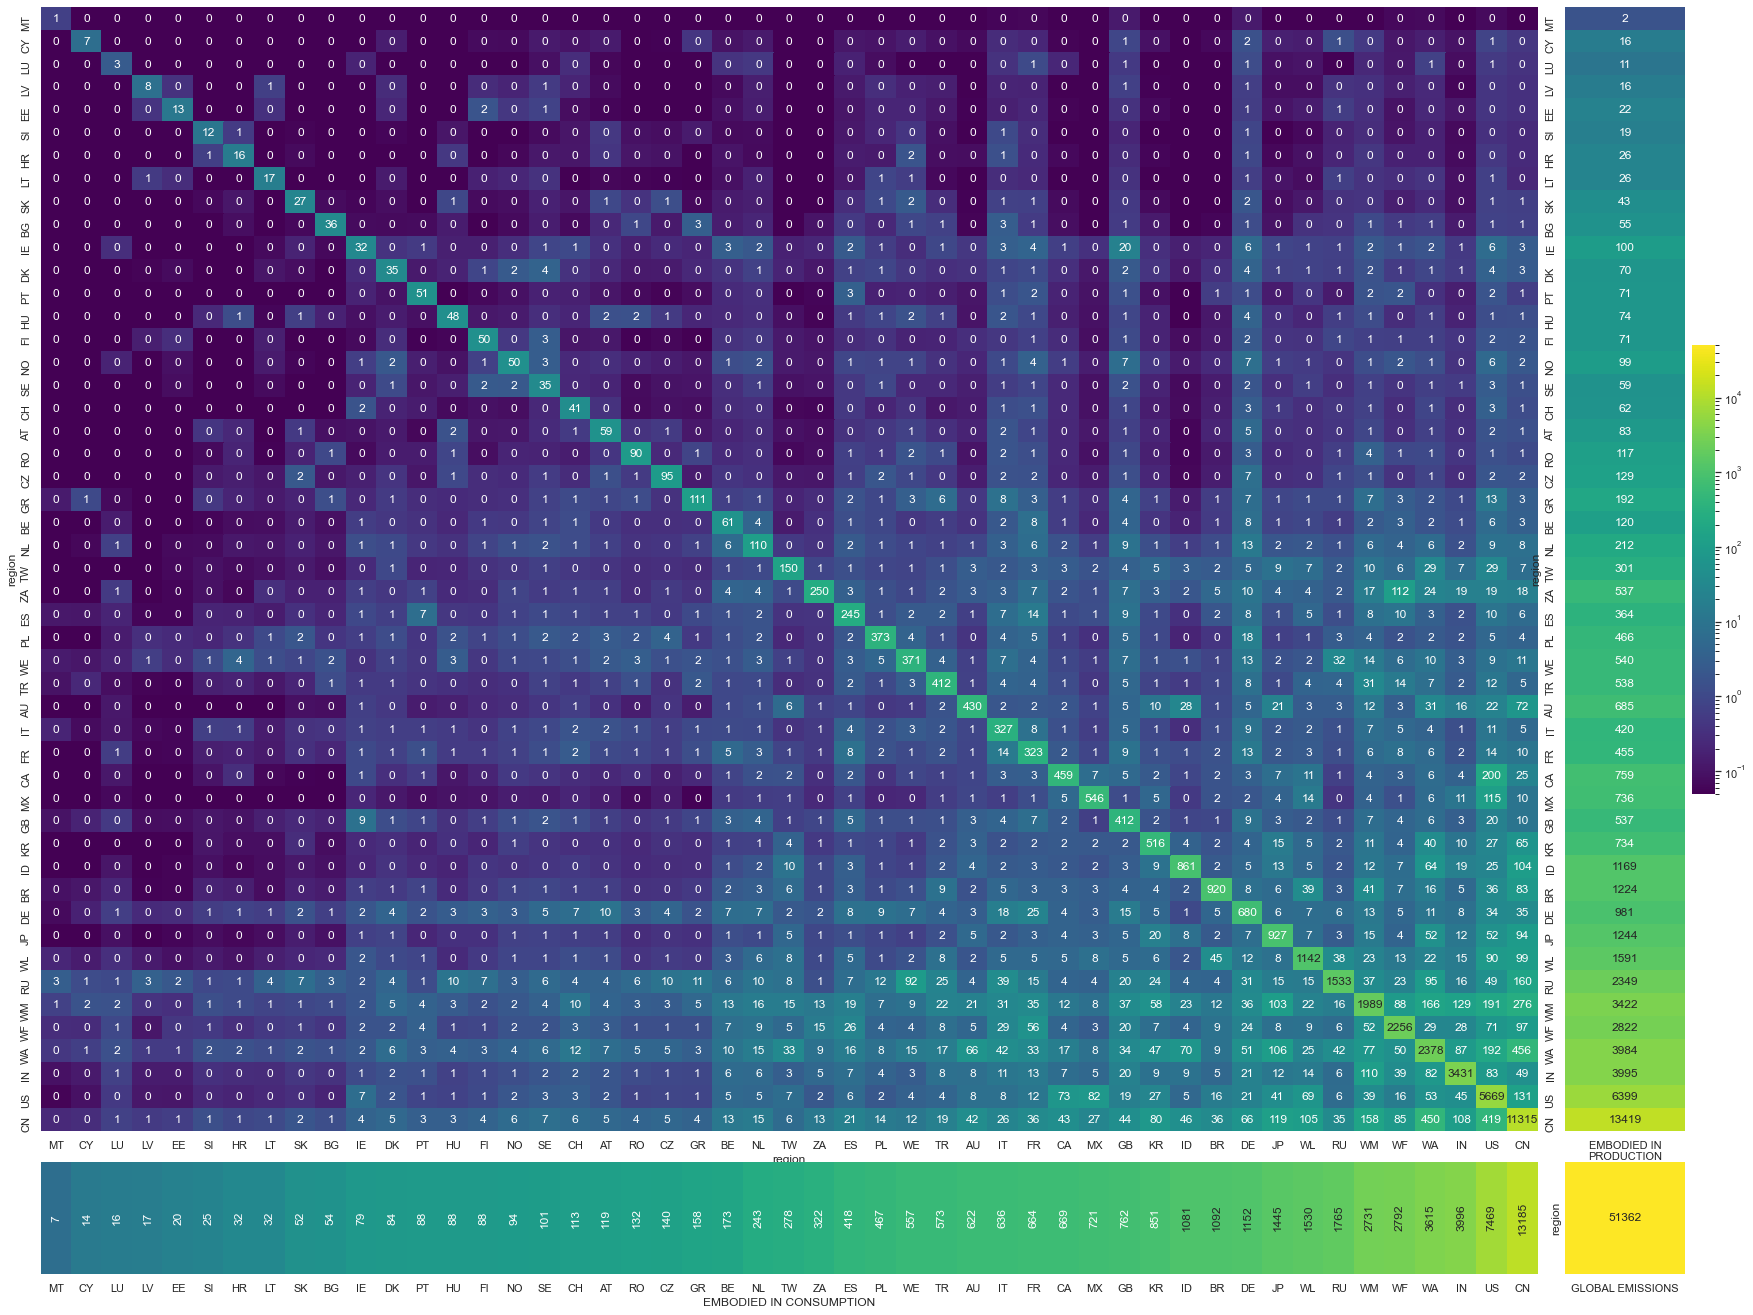

In [155]:
max_r = 49 # EU = 28, All = 49
cmap  = 'viridis'

GHG_cons_cutoff=GHG_cons.drop(GHG_cons.index[max_r:-1],axis=0).drop(GHG_cons.columns[max_r:-1],axis=1)

GHG_cons_sorted=GHG_cons_cutoff.sort_values(by='EMBODIED IN\nCONSUMPTION', axis=1)
GHG_cons_sorted=GHG_cons_sorted.reindex([*GHG_cons_sorted.columns[:-1],'EMBODIED IN\nCONSUMPTION'], axis=0)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(30, 20),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 1],
                                    'height_ratios': [10, 1],
                                    'wspace': 2/3*0.05,
                                    'hspace': 0.05,
                                    'bottom': 0})

sns.heatmap(GHG_cons_sorted.iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,0])
sns.heatmap(GHG_cons_sorted[GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,1])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:]].iloc[:max_r,:max_r], annot=True,
            annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[1,0])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:],GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='.0f',
           ax=ax[1,1])

ax[1,1].set_xlabel('')
ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION')
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])

# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.png'.format(year),
            facecolor='white',
            edgecolor='none')